In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)


# 1. Preprocess datasets

### Read csv file

In [2]:
artists = pd.read_csv('/home/ubuntu/Untitled Folder/artists.csv',low_memory = True )
artists


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


### Preprocess artists datasets

In [3]:
artists = artists.sort_values(by=['paintings'], ascending=False)

artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


### Plot some random images
- set the size of the image to 224 x 224 x 3

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


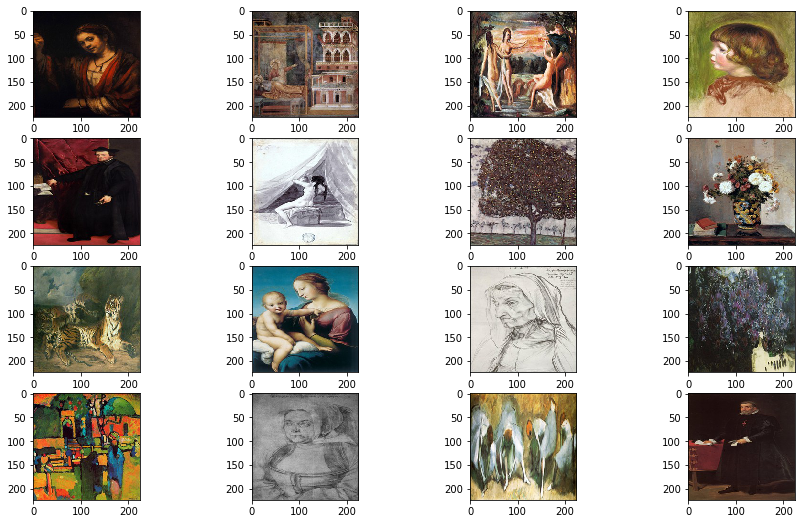

In [7]:
import random
from PIL import Image 
from skimage.io import imread

images_dir = 'images'
artists_names = artists['name'].str.replace(' ', '_').values
artists_top = artists[artists['paintings'] >= 200].reset_index()

images = []
for folder in os.listdir(images_dir):
    for image in os.listdir(images_dir + '/' + folder):
        images.append(os.path.join(images_dir, folder, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
    n += 1
    random_img = random.choice(images)
    imgs = imread(random_img)
    plt.subplot(4, 4, n)
    #axis('off')
    plt.imshow(imgs)
    print(imgs.shape)
plt.show()

### Use 'images2' to store all artwork directories from each artists

In [35]:
images2 = []
for folder in os.listdir(images_dir):
    for image in os.listdir(images_dir + '/' + folder):
        images2.append(os.path.join(images_dir, folder, image))

In [36]:
images2

['images/Jan_van_Eyck/Jan_van_Eyck_63.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_71.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_13.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_10.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_66.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_15.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_8.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_41.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_78.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_7.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_74.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_65.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_75.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_58.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_55.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_14.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_11.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_54.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_6.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_67.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_42.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_77.jpg',
 'images/Jan_van_Eyck/Jan_van_Eyck_

# 2. Vgg16 cosine similarity to find the most similar products

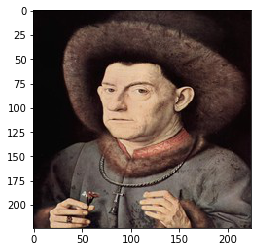

image loaded successfully!


In [9]:

from keras.preprocessing.image import load_img,img_to_array
original = load_img(images[0], target_size=(224, 224))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

### Create image batches, preprocess inputs
- convert the PIL image to numpy array
- convert the images to batch form

In [10]:
from keras.applications.imagenet_utils import preprocess_input

numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
processed_image = preprocess_input(image_batch.copy())


image batch size (1, 224, 224, 3)


### Implement VGG16 models to be futuer used

In [11]:
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Get the extracted features as an array
- Use the feature extractor trained by VGG16 to extract image features

In [12]:
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[ 0.5430084, -0.       , -0.       , ..., -0.       , -0.       ,
         0.9395176]], dtype=float32)

### Load all images from image directory and feed them into CNN

In [20]:
importedImages = []

for f in images:
    if f.endswith('.jpg'):
        filename = f
        original = load_img(filename, target_size=(224, 224))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)

        importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

### Extract image features

In [21]:
imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape


features successfully extracted!


(8446, 4096)

### Compute Cosine Similarities for every image, sort descendingly to retrive the most similar artworks

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

cosSimilarities = cosine_similarity(imgs_features)


In [42]:
cosSimilarities

array([[0.9999998 , 0.4937119 , 0.3152465 , ..., 0.17403463, 0.18056297,
        0.36910912],
       [0.4937119 , 1.0000002 , 0.37944177, ..., 0.27749538, 0.22440486,
        0.4223755 ],
       [0.3152465 , 0.37944177, 0.99999976, ..., 0.25665903, 0.20781635,
        0.30262357],
       ...,
       [0.17403463, 0.27749538, 0.25665903, ..., 1.0000001 , 0.27876875,
        0.4261105 ],
       [0.18056297, 0.22440486, 0.20781635, ..., 0.27876875, 1.0000001 ,
        0.31651002],
       [0.36910912, 0.4223755 , 0.30262357, ..., 0.4261105 , 0.31651002,
        1.        ]], dtype=float32)

### Cosine Similarity matrix 

In [45]:
file_correct = []
for f in images2:
    if f.endswith('.jpg'):
        file_correct.append(f)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=file_correct, index=file_correct)
cos_similarities_df.head()

,images/Jan_van_Eyck/Jan_van_Eyck_63.jpg,images/Jan_van_Eyck/Jan_van_Eyck_71.jpg,images/Jan_van_Eyck/Jan_van_Eyck_13.jpg,images/Jan_van_Eyck/Jan_van_Eyck_10.jpg,images/Jan_van_Eyck/Jan_van_Eyck_66.jpg,images/Jan_van_Eyck/Jan_van_Eyck_15.jpg,images/Jan_van_Eyck/Jan_van_Eyck_8.jpg,images/Jan_van_Eyck/Jan_van_Eyck_41.jpg,images/Jan_van_Eyck/Jan_van_Eyck_78.jpg,images/Jan_van_Eyck/Jan_van_Eyck_7.jpg,...,images/Edvard_Munch/Edvard_Munch_37.jpg,images/Edvard_Munch/Edvard_Munch_34.jpg,images/Edvard_Munch/Edvard_Munch_55.jpg,images/Edvard_Munch/Edvard_Munch_60.jpg,images/Edvard_Munch/Edvard_Munch_54.jpg,images/Edvard_Munch/Edvard_Munch_21.jpg,images/Edvard_Munch/Edvard_Munch_52.jpg,images/Edvard_Munch/Edvard_Munch_56.jpg,images/Edvard_Munch/Edvard_Munch_43.jpg,images/Edvard_Munch/Edvard_Munch_38.jpg
images/Jan_van_Eyck/Jan_van_Eyck_63.jpg,1.000000,0.493712,0.315246,0.592450,0.512293,0.539140,0.327623,0.206374,0.208424,0.466058,...,0.307759,0.200314,0.328816,0.288787,0.268532,0.385522,0.375822,0.174035,0.180563,0.369109
images/Jan_van_Eyck/Jan_van_Eyck_71.jpg,0.493712,1.000000,0.379442,0.618408,0.451197,0.469327,0.491517,0.390012,0.275357,0.579764,...,0.286726,0.272560,0.362405,0.352243,0.241233,0.458200,0.342129,0.277495,0.224405,0.422376
images/Jan_van_Eyck/Jan_van_Eyck_13.jpg,0.315246,0.379442,1.000000,0.348426,0.355321,0.229269,0.288077,0.224798,0.204930,0.299612,...,0.219564,0.269714,0.420478,0.237789,0.188696,0.278542,0.277095,0.256659,0.207816,0.302624
images/Jan_van_Eyck/Jan_van_Eyck_10.jpg,0.592450,0.618408,0.348426,1.000000,0.589476,0.525359,0.336935,0.330241,0.214395,0.433100,...,0.318745,0.240550,0.415030,0.305434,0.285253,0.455821,0.421648,0.311964,0.147830,0.412237
images/Jan_van_Eyck/Jan_van_Eyck_66.jpg,0.512293,0.451197,0.355321,0.589476,1.000000,0.343089,0.315639,0.245153,0.220737,0.365377,...,0.293062,0.198335,0.336077,0.212329,0.194269,0.298559,0.302653,0.183758,0.124512,0.331966


### To retrieve the most similar products

images/Jan_van_Eyck/Jan_van_Eyck_63.jpg
-----------------------------------------------------------------------
original product:


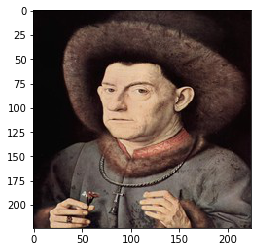

-----------------------------------------------------------------------
most similar products:


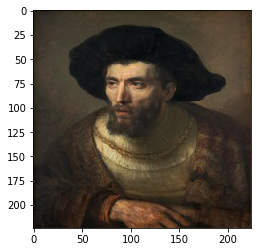

similarity score :  0.67465293


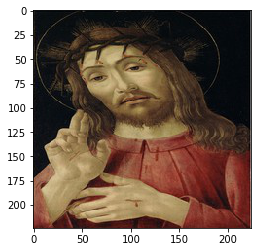

similarity score :  0.66667825


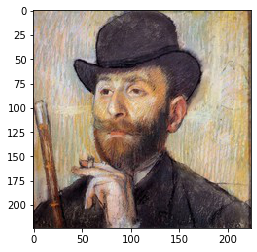

similarity score :  0.6532838


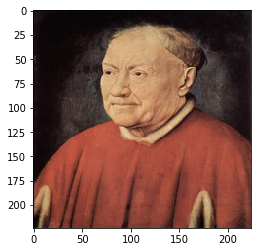

similarity score :  0.65310496


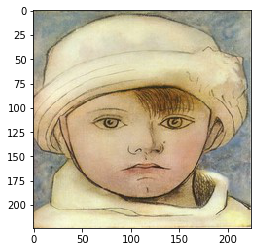

similarity score :  0.65040374


In [47]:
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")
    
    original = load_img(given_img, target_size=(224, 224))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:5+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:5+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(224, 224))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])
        
name_image = images2[0]  
print(name_image)
retrieve_most_similar_products(images2[0])


# 3. CNN to identify artworks

In [6]:
artists_name = artists['name'].unique()
artists_name = [s.replace(' ','_') for s in artists_name]
artists_name.remove('Albrecht_Dürer')

### Read images from directory, resize images using cv2 library

In [7]:
import cv2

img_size = 224
def get_data(data_dir):
    data = [] 
    for label in artists_name: 
        path = os.path.join(data_dir, label)
        class_num = artists_name.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
#0805
data = get_data('images')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion faile

### A simple visualization to the distribution of each artists' selective artworks

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

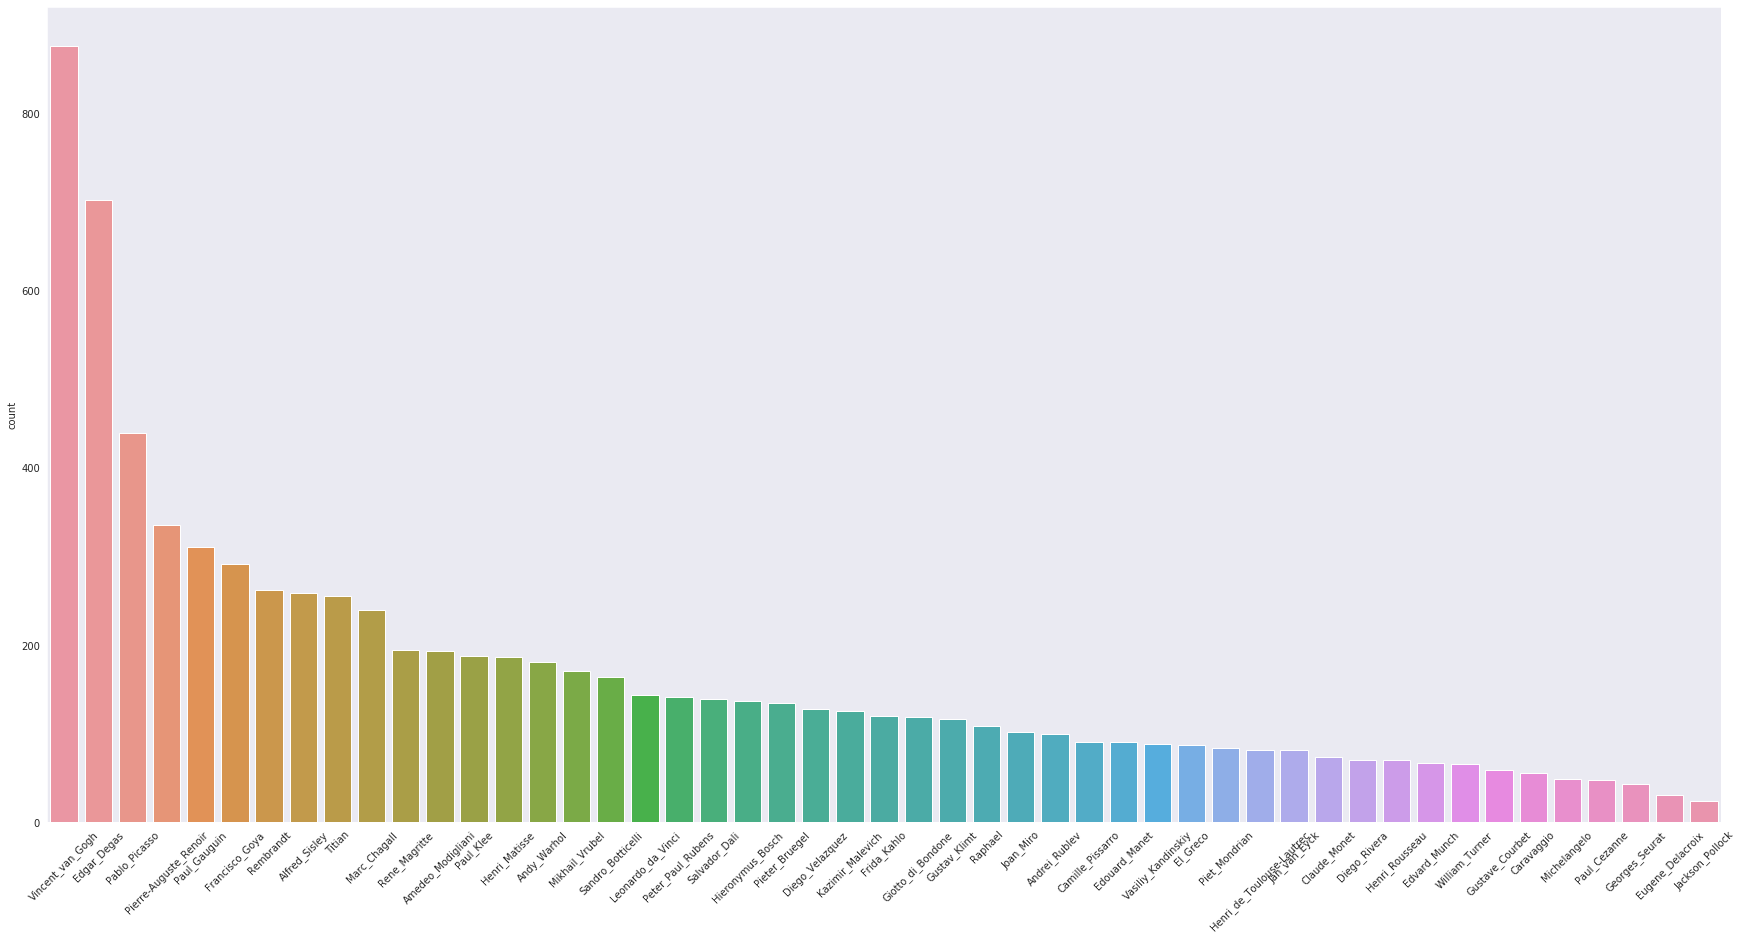

In [11]:
import seaborn as sns

fig = plt.figure(figsize=(30,15))
fig.patch.set_facecolor('white')
l = []
for i in data:
    l.append(artists_name[i[1]])
sns.set_style('dark')
sns.countplot(l)
plt.xticks(rotation=45)

In [12]:

x = []
y = []

for feature, artists_name in data:
    x.append(feature)
    y.append(artists_name)

In [13]:
x = np.array(x) / 255

### Reshaping the data from 1-D to 3-D as required through input by CNN's 


In [14]:
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)


### Lablelize the dataset and split them into train and test

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [16]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , random_state = 0)

### Resize both train and test directory images

In [12]:
from PIL import Image
import os, sys
import glob

def resize(dire):
    for folder in os.listdir(dire):
        for filename in glob.iglob(dire + '/' + folder + '**/*.jpg', recursive=True):
            #print(filename)
            im = Image.open(filename)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save(filename , 'JPEG', quality=90)

    
train = resize(train_dir)
test = resize(test_dir)
validation = resize(val_dir)


trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_63.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_13.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_10.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_66.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_15.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_8.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_41.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_78.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_7.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_74.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_65.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_58.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_14.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_11.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_6.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_67.jpg
trained_image_file/train/Jan_van_Eyck/Jan_van_Eyck_42.jpg
trained_image_fil

In [18]:
def get_image(dire):
    all_images = []
    for folder in os.listdir(dire):
        for image in os.listdir(dire + '/' + folder):
            all_images.append(os.path.join(dire, folder, image))

    all_images = np.asarray(all_images)
    return all_images
    

get_my_image = get_image(images_dir)
#train_images[9]
get_my_image[9]

'images/Jan_van_Eyck/Jan_van_Eyck_7.jpg'

In [14]:
conda install -c conda-forge keras tensorflow


Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37

  added / updated specs:
    - keras
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boto3-1.9.66               |           py37_0         107 KB
    botocore-1.12.189          |             py_0         2.6 MB
    docutils-0.16              |           py37_0         668 KB
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    s3transfer-0.1.13          |           py37_0          80 KB
    ------------------------------------------------------------
                                           Total:         5.6 MB

The following packages will be UPDATED:

  docutils              conda-forge::docutils-0.15.2-py37_0 --> pkgs/main::docutils-0.16-py37_0
  openssl                                 1.1.1g-h516909a_0 --> 1.1.1g-

### Augment data using generators 

In [20]:
IMG_SIZE = (224,224)
datagen=ImageDataGenerator(rescale=1./255)
batch_size = 150
train_generator = datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42)
validation_generator = datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 6735 images belonging to 54 classes.
Found 821 images belonging to 54 classes.


### classification model with accuracy 60%

In [35]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
from keras import regularizers

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:10]:
    layer.trainable = False

for layer in pre_trained_model.layers[10:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    


x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)


model = Model(pre_trained_model.input, x)


model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['acc'])

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Resnet based model with accuracy 96%

In [18]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.6, min_lr=0.000001)

In [16]:
from keras import layers

image_size = 224
input_shape = (image_size, image_size, 3)


pre_trained_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:10]:
    layer.trainable = False

    

X = pre_trained_model.output
X = Flatten()(X)
# Add a fully connected layer with 512 hidden units and ReLU activation
X = Dense(512, activation='relu')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
# Add a dropout rate of 0.5
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
# Add a final sigmoid layer for classification
#X = layers.Dense(49, activation='sigmoid')(X)

output = layers.Dense(49, activation='softmax')(X)

model = Model(pre_trained_model.input, output)


model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 25 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/25
102/102 [==============================] - 2000s 20s/step - loss: 2.6240 - accuracy: 0.3779 - val_loss: 4.1663 - val_accuracy: 0.0142 - lr: 1.0000e-04
Epoch 2/25
102/102 [==============================] - 2005s 20s/step - loss: 1.0152 - accuracy: 0.7779 - val_loss: 3.9826 - val_accuracy: 0.0185 - lr: 1.0000e-04
Epoch 3/25
102/102 [==============================] - 2005s 20s/step - loss: 0.4511 - accuracy: 0.9386 - val_loss: 4.0321 - val_accuracy: 0.0252 - lr: 1.0000e-04
Epoch 4/25
  1/102 [..............................] - ETA: 0s - loss: 0.2729 - accuracy: 0.9844

KeyboardInterrupt: 